In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  5 15:15:17 2018

Ca transient event detection, adapted from Dombeck 2007

This is based on the MATLAB implementation of detect_ca_transients_mossy which 
was written by Jessica Jimenez, Columbia University, jcj2123@columbia.edu

@author: Saveliy Yusufov, Columbia University, sy2685@columbia.edu
"""
import math
import numpy as np
import pandas as pd
import peakutils.peak
from itertools import cycle
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn')
%matplotlib inline

def detect_ca_transients_mossy(data, thresh, baseline, t_half, frame_rate):
    """
    Args:
        data = (raw_cell) Ca2 transient data in T x N format, where N = # of cells (columns), T = time (rows), raw format
        thresh = minimum aplitude size of ca transient data in s.d.
        baseline = s.d. offset value of ca transient
        t_half = half life og gcamp type used (s)
        frame_rate = framerate of raw_cell
    
    Returns:
        cell_transients = T x N matrix with s.d. vlaues for all the timepoints of the qualified transients (all zeroes except for transients, red trace in fig)
        cell_events = T x N matrix with calcium transient peak events (all zeroes except for the amplitude value at the peak timepoint of each transiwnt, asterik in fig)
        cell_AUC = T x N matrix with calculuc transient area under the curve (AOC) values (all zeroes except for the AOC value assigned to the peak timepoint of each transient)
        zscored_cell = T x N matrix with zscored raw_cell data (blue trac in fig)
    """
    
    # zscore all data
    
    # Generate single vector with all cell fluorescence values
    pophist = list()
    for column in data:
        pophist += data[column].tolist()
    
    #print(pophist)
    
    # Find the 50% quantile value (for "silent" time points)
    pop_offset = np.percentile(pophist, 50)
    # print(pop_offset)
    
    # Find timepoints without ca transients based on threshold above
    silent = [1 if pophist[i] < pop_offset else 0 for i in range(0, len(pophist))]
    # print(silent)
    
    # Specify mu from the silent timepoints
    mu = np.mean([pophist[i] for i in range(0, len(silent)) if silent[i] == 1])

    # Specify sigma from the entire time series
    sigma = [np.std(data[column].tolist()) for column in data]

    # Convert transients into zscores using mu from silent timepoints and sigma from all timepoints
    zscored_cell = (data - mu) / sigma

    cell_data = zscored_cell
    # print(zscored_cell)

    # Preallocate outputs
    # cell_events = zeros(cell_data_size)
    cell_transients = pd.DataFrame(np.zeros(shape=(data.shape[0], data.shape[1])))
    cell_AUC_df = pd.DataFrame(np.zeros(shape=(data.shape[0], data.shape[1])))
    
    # Define minimum duration of calcium transient based on gcamp type used
    
    # Simplified from (-ln(A / Ao) / t_half), [A / Ao] = 0.5 at t half-life, [-ln(A / Ao)] = 0.693
    # TODO: No magic numbers!!!
    decayrate = 0.693 / t_half 
    # print(decayrate)
    
    # Minimum (s) duration for ca transient of minimum specified s.d. amplitude threshold
    minimum_duration = -(math.log(baseline / thresh)) / decayrate 
    # print(minimum_duration)
    
    # Minimum number of frames the ca transient should last above baseline
    minimum_frames = round(minimum_duration * frame_rate) 
    # print(minimum_frames)
    
    # Identify qualified ca transients and generate outputs
    onset = list()
    offset = list()
    for column in data:
        
        # Find all timepoints where flourescence greater than threshold
        onset = cell_data.index[cell_data[column] > thresh].tolist()
        
        # Find all timepoints where floursecence greater than baseline (transient offset)
        offset = cell_data.index[cell_data[column] > baseline].tolist()

        found = True

        for m in range(0, len(offset) - 1):
            if found:

                # Specify start index of transient from offset vector
                start = offset[m] 

                found = False

            # Specify stop index of transient from offset vector
            if offset[m + 1] - offset[m] > 1: 

                finish = offset[m];

                # Find the peak value in that start-stop range
                MAX = max(cell_data[column][start:finish+1].tolist())
                I = cell_data[column][start:finish+1].tolist().index(max(cell_data[column][start:finish+1].tolist()))
                transient_vector = list(range(start, finish+1))
                # print(MAX)
            
                # Retrieve "cell" index of that peak value
                max_amp_index = transient_vector[I]
                
                # print(max_amp_index)

                peak_to_offset_vector = list(range(max_amp_index, finish + 1))
                
                # print(peak_to_offset_vector)
                
                found = True;

                # If the peak value index from start-stop in offset is also found in onset vector, 
                # then the transient exceeded the 2SD threshold
                if (max_amp_index in onset) and len(peak_to_offset_vector) >= minimum_frames: 

                    # Retrieve "cell" values for all the timepoints of that transient
                    cell_transients[column][start:finish+1] = cell_data[column][start:finish+1] 

                    # Create a matrix with all the calcium transient peak events  
                    # (all zeros except for the amplitude value at the peak timepoint)
                    # cell_events(maxamp_ind, k) = M     

                    # Integrate the area under the curve of the transient from start-stop
                    transient_area = np.trapz(cell_data[column][start:finish+1].tolist())
                    # print(transient_area)
                    
                    # Create a matrix with all the calcium transient AOC values 
                    # (all zeros except for the AOC value assigned to the peak timepoint)
                    cell_AUC_df[column][max_amp_index] = transient_area   

    """
    # Detect multi-peak transients and update in cell_events
    for k = 1:size(cell_transients, 2):

        # built-in matlab 'findpeaks' fxn
        [~, time] = findpeaks(cell_transients(:, k), 'MinPeakProminence', 1.5, 'MinPeakDistance', frame_rate) 

        # Minpeak distance is 1 sec (as specified by your frame rate), and min peak
        # Prominence must be 1.5SD in size
        cell_events(time, k) = cell_transients(time, k) # cell events with multi-peak transients added

    # TODO: What is this? And how should it be plotted?
    # Plot and save figures with event detection results
    X = (1:size(cell_events, 1))
    events = cell_events
    events[events == 0] = np.nan

    for i = 1:size(cell_events, 2):
        figure(i)
        plot(zscored_cell(:, i), 'b')
        plot(cell_transients(:, i), 'r')
        plot(X, events(:, i), 'm*')
        title(['Cell', num2str(i)], 'Fontsize', 10);
    """

    return [cell_data, cell_AUC_df, cell_transients]

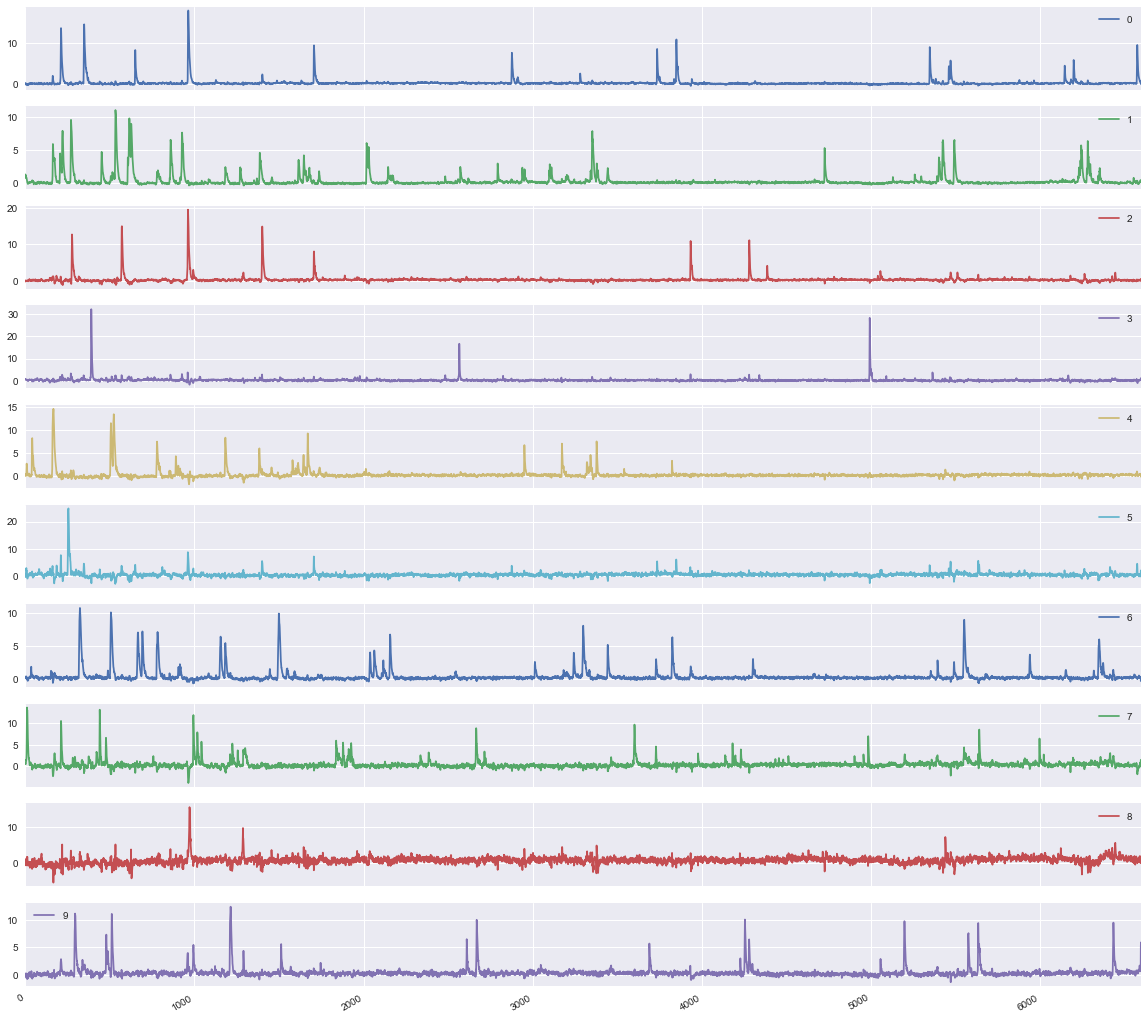

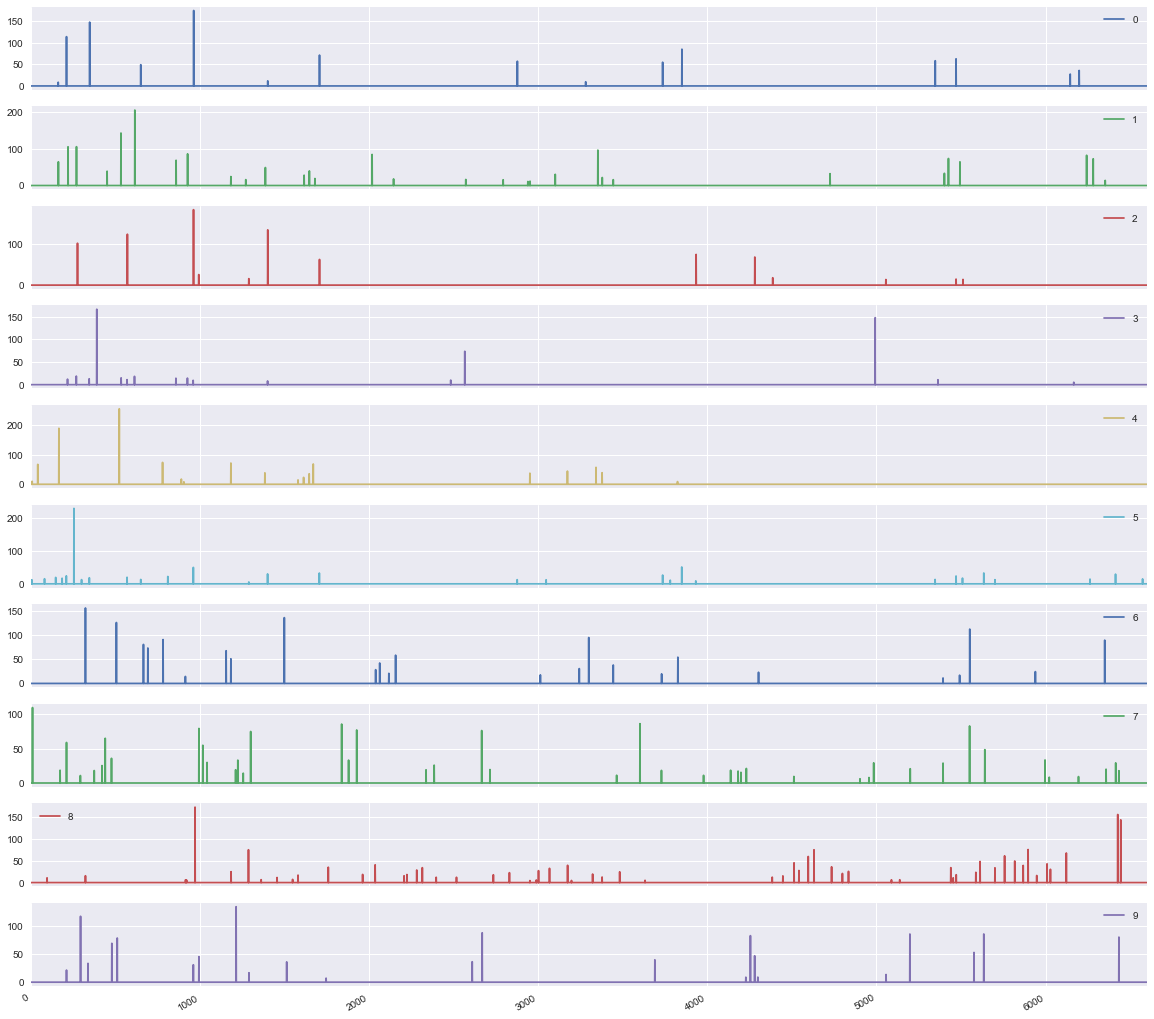

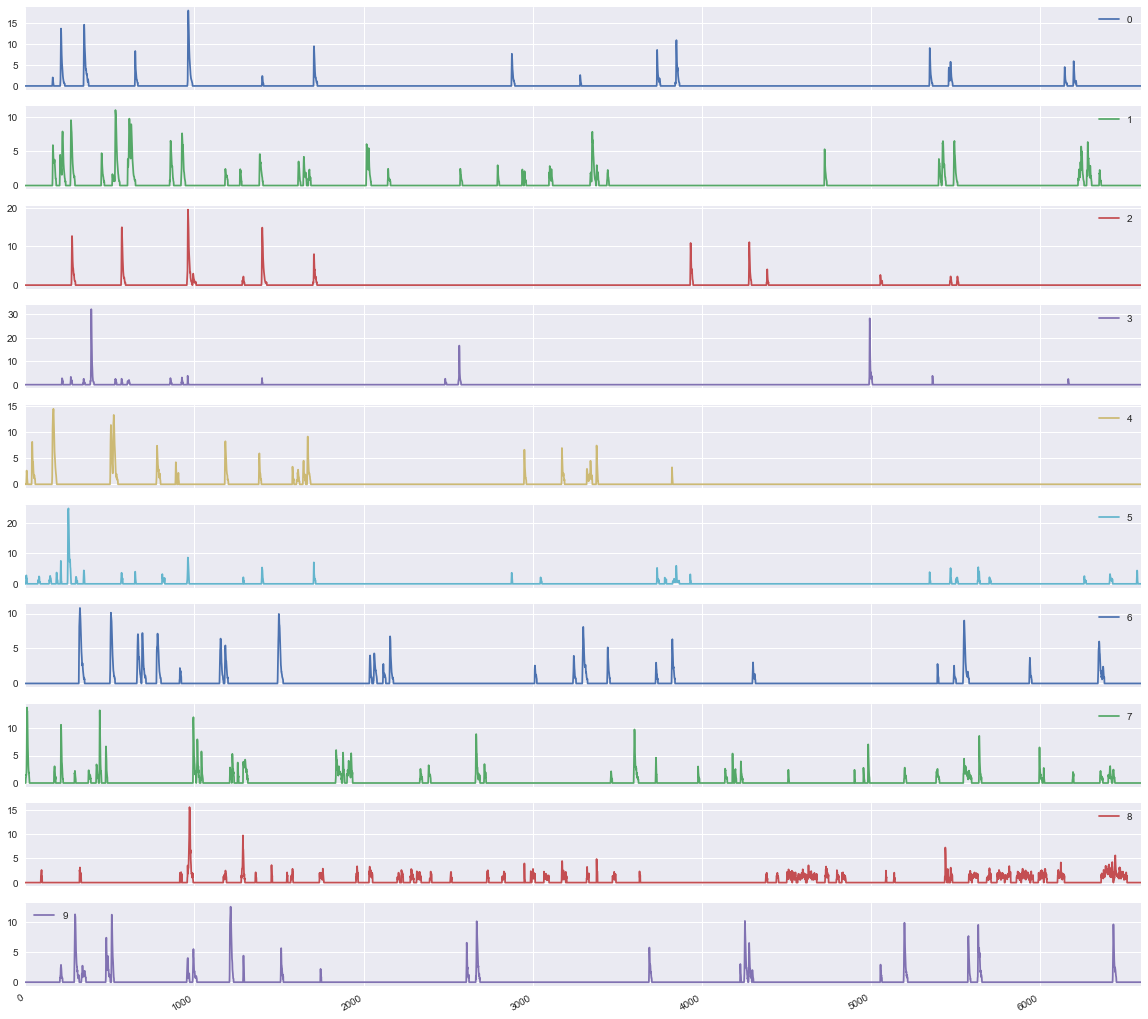

In [10]:
data = pd.read_csv('~/TraceRaw_Mouse_drd46.csv', header=None)
lst_of_dataframes = detect_ca_transients_mossy(data, 2, .5, 0.2, 10)

# lst_of_dataframes[2]

lst_of_dataframes[0].plot(subplots=True, figsize=(20, 20));
lst_of_dataframes[1].plot(subplots=True, figsize=(20, 20));
lst_of_dataframes[2].plot(subplots=True, figsize=(20, 20));

# Graphs of neuron activity with events marked 
##### (Test to find Python equivalent of findpeaks() in MATLAB)

In [ ]:
# Graph each column in the Dataframe, with distinguishing markers for local maxima
cycol = cycle('bgcmky')
for column in data:
    indices_of_peaks = peakutils.indexes(data[column], thres=0.35, min_dist=30)
    plt.figure()
    data[column].plot(figsize=(15, 2), c=next(cycol))
    plt.plot(data[column][indices_of_peaks], c='r', marker="o", ls="", ms=7)